In [1]:
# Used for jupyter-notebook environment
#%matplotlib inline

# Used for jupyter-lab environment
#%matplotlib widget

In [2]:
# Import the required modules
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import re # For regular expressions
from pprint import pprint # pretty printing of dicts
from math import floor, ceil

import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, max_error, accuracy_score, 

#from scipy.interpolate import RBFInterpolator

from pydmd import DMD
import pysindy as ps
from PDE_FIND import *

In [3]:
# Find the data to load
path = '../Experimental data/Heat conduction processed/' # Define experimental data path
files = []
experiments = {}
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if re.search("csv$", filename):  # Search if filename ends in 'csv'
            experiments.update({filename.split('.')[0]:[(os.path.join(dirname,filename))]})

#pprint(experiments)

In [4]:
# Remove any unwanted files - eg .ipynb_checkpoints
experiments_dummy = experiments.copy() # Create dummy variable so dict does not change while iterating
for name, values,  in experiments.items():
    path = values[0]
    if re.search("ipynb_checkpoints", path):
        del(experiments_dummy[name])
experiments = experiments_dummy
#pprint(experiments)

In [5]:
# Create sensible variable names for the files
from operator import itemgetter
experiments_new = {}
for name, values in experiments.items():
    path = values[0]
    names = name.split()
    title = list(itemgetter(1,3,-2,-1)(names))
    title = str(" ".join(title)).capitalize()
    values.append(title)
    if names[-2] == 'single':
        names[4] = 'ss'
    elif names[-2] == 'double':
        names[4] = 'ds'
    names = list(itemgetter(1,4,3)(names))
    var_name = str("_".join(names))
    experiments_new[var_name] = tuple(values)

experiments = experiments_new
pprint(experiments)

{'aluminium_ss_dry': ('../Experimental data/Heat conduction processed/Narrow '
                      'aluminium 2kg dry single side.csv',
                      'Aluminium dry single side'),
 'aluminium_ss_oil': ('../Experimental data/Heat conduction processed/Narrow '
                      'aluminium 2kg oil single side.csv',
                      'Aluminium oil single side'),
 'steel_ds_silicone': ('../Experimental data/Heat conduction processed/Narrow '
                       'steel 2kg silicone htc double side.csv',
                       'Steel silicone double side'),
 'steel_ss_dry': ('../Experimental data/Heat conduction processed/Narrow steel '
                  '2kg dry single side.csv',
                  'Steel dry single side'),
 'steel_ss_oil': ('../Experimental data/Heat conduction processed/Narrow steel '
                  '2kg oil single side.csv',
                  'Steel oil single side'),
 'steel_ss_silicone': ('../Experimental data/Heat conduction processed/Narrow '
 

In [16]:
# Define Experiment class with all methods for the experiments.

from weakref import WeakSet

class Experiment(object):
    """
    Create an instance of the class "Experiment".
    """
    
    instances = WeakSet()
    
    def __init__(self, *, title, timestep=5, plot=True, save_fig=False, **kwargs):
        """
        Docstring:
        Takes the path of the input file is csv format,
        stores it in a dataframe with columns for each timestep
        and rows for each pixel.
        
        Parameters:
        -----------
        *argv:
            title: the title used for plots
            timestep: the time interval between each data snapshot
            plot: plot a surface plot of the raw data. default=True
            save_fig: save the plot of the raw data in .png format. default=False
        
        Other parameters:
        -----------------
        **kwargs:
            file: path to csv file of data
            data: raw python data to be converted into pandas dataframe
        
        Returns:
        --------
        Plots a surface plot of the input data
        
        """
        if "file" in kwargs:
            self.file = kwargs.get("file")
            self.data = pd.read_csv(self.file)
        elif "data" in kwargs:
            self.data = pd.DataFrame(kwargs.get("data"))
        else:
            raise Exception("Input data or file required instantiate Experiment class")
            
        self.timestep = timestep
        self.data.columns.name = 'time [$s$]'
        self.data.columns = self.data.columns.astype(int)*timestep
        self.data.index.name = 'pixel'
        self.title = title
        
        print(f"Adding instance: '{self.title}'.")
        Experiment.instances.add(self)
        
        if ((plot==True) or (save_fig==True)):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d", title=f"Surface plot of {title.lower()}'s data",
                                 xlabel="Pixel #", ylabel="Time [s]", zlabel="Temperature [C]")
            X, Y = np.meshgrid(self.data.index, self.data.columns)
            surf = ax.plot_surface(X, Y, self.data.to_numpy().T, cmap="jet")
            fig.colorbar(surf, label="Temperature [C]")
            
            if (plot==True):
                plt.show()
        
        if (save_fig == True):
            fname =f"{self.title} surface plot.png"
            fig.get_figure().savefig(fname)
    
    def set_meta_params(self, *, set_global=True, plot_2d=False, plot_3d=False, plot_3d_reduced=False, **kwargs):
        """
        Docstring:
        Set parameters to reduce the amount of data in the dataframe.
        Note that all arguments should be passed at once, else the default values will be used
        
        Parameters:
        ----------
        *argv:
            set_global = set meta parameters for instance using new parameters.
            plot_2d: option to show where meta paramaters cut plot in 2d. default=False
            plot_3d: option to show where meta paramaters cut plot in 2d. default=False
        **kwargs:
            start_pix: starting pixel. defualt=70
            end_pix: ending pixel. defualt=500
            pix_spacing: spacing between pixels. defualt=50
            start_t: first timestep to include in dataset. defualt=0
            end_t: last timestep to include in dataset. defualt=data.columns[-1]
            t_interval: spacing between desired samples of time defualt = 500s
        
        Returns
        -------
        None
        """
        
        self.meta = {
            "start_pix": kwargs.get("start_pix", 70),
            "end_pix": kwargs.get("end_pix", 500),
            "pix_spacing": kwargs.get("pix_spacing", 50),
            "start_t": kwargs.get("start_t", 0),
            "end_t": kwargs.get("end_t", self.data.columns[-1]),
            "t_interval": kwargs.get("t_interval", 5)
            }
        
        print(self.meta)

        if self.meta["t_interval"]%self.timestep !=0:
            raise Exception("t_interval needs to be divisible by the timestep")
        
        if (set_global==True):
            self.reduced_data = self.reduce_data(**self.meta)
        
        if plot_2d==True:
            self.data.plot()
            plt.title(f"Plot of {self.title.lower()}'s data at {self.meta['t_interval']}s intervals")
            plt.grid()
            plt.ylabel("Temperature [$\deg C$]")
            plt.xlabel("pixel")
            plt.axvline(self.meta["start_pix"], c='k', linestyle='--')
            plt.axvline(self.meta["end_pix"], c='k', linestyle='--')
            plt.legend().remove()
            plt.show()
        
        if plot_3d:
            #raise Exception("Unknown bug causes kernel to crash for some reason, so function is passed")
            #pass # Causes kernel to crash for some reason, so pass
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d", title=f"Surface plot of {title.lower()}'s data", xlabel="Pixel #",
                                 ylabel="Time [s]", zlabel="Temperature [C]")
            X, Y = np.meshgrid(self.data.index, self.data.columns)
            surf = ax.plot_surface(X, Y, self.data.to_numpy().T, cmap="jet")
            ys = np.arange(0, self.data.columns.max(), self.meta["t_interval"])
            zs = np.linspace(0, self.data.max(), np.shape(ys)[0])
            yy, zz = np.meshgrid(ys, zs)
            xx1 = self.meta["start_pix"]
            xx2 = self.meta["end_pix"]
            ax.plot_surface(xx1, yy, zz)
            ax.plot_surface(xx2, yy, zz)
            fig.colorbar(surf, label="Temperature [C]")
            plt.show()
        
        if plot_3d_reduced:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d", title=f"Surface plot of {self.title.lower()}'s reduced data set", xlabel="Pixel #",
                                 ylabel="Time [s]", zlabel="Temperature [C]")
            X, Y = np.meshgrid(self.reduced_data.index, self.reduced_data.columns)
            surf = ax.plot_surface(X, Y, self.reduced_data.to_numpy().T, cmap="jet")
            ys = np.arange(0, self.reduced_data.columns.max(), self.meta["t_interval"])
            zs = np.linspace(0, self.reduced_data.max(), np.shape(ys)[0])
            yy, zz = np.meshgrid(ys, zs)
            fig.colorbar(surf, label="Temperature [C]")
            plt.show()
    
    def reduce_data(self, **kwargs):
        """
        Docstring:
        Reduce a full dataframe with time as columns and pixels as rows
        to a smaller dataframe according to the paramaters inherited from 
        'meta' or parameters set with **kwargs.
        
        Parameters:
        ----------
        **kwargs:
            start_pix: starting pixel.
            end_pix: ending pixel.
            pix_spacing: spacing between pixels.
            start_t: first timestep to include in dataset.
            end_t: last timestep to include in dataset.
            t_interval: spacing between desired samples of time.
            
        Returns:
        --------
        the data from the full set reduced according to the specified parameters
        """
        _meta = self.meta.copy()
        
        for arg in kwargs:
            _meta.update({arg:kwargs.get(arg)})
            
        if _meta["t_interval"]%self.timestep !=0:
            raise Exception("t_interval needs to be divisible by the timestep")
        
        print(f"Using meta parameters {_meta}")
        reduced_data = self.data.loc[_meta["start_pix"]:_meta["end_pix"]:_meta["pix_spacing"],
                                     range(_meta["start_t"], _meta["end_t"]+1, _meta["t_interval"])]
        return(reduced_data)
    
    def time_seriesCV(self, data, *, n_splits=5):
        """
        Docstring:
        Perform splitting of time series data into train and test samples.
        See 'sklearn.model_selection.TimesSeriesSplit' for more information.
        
        Parameters:
        ----------
        n_splits: number of splits. default = 5
        data: data to split into training and test sets. if 'None', uses self.reduced_data
        
        Returns:
        --------
        X_train, X_test, y_train, y_test
        """
        print(f"{self.title}'s creation of cross validation data sets")
        
        self.CV_data = dict()
        
        if (data==None):
            data = self.reduced_data.transpose()
            
            X = np.zeros_like(data, dtype=tuple)
            
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    X[i,j] = (i *self.timestep, j)
        
        y = data.to_numpy()
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        cv_set = 1
        
        for train_index, test_index in tscv.split(data):
            
            print(f"CV {cv_set}:\t TRAIN times:[{self.timestep*train_index[0]}:{self.timestep*train_index[-1]}]s \t TEST times: [{self.timestep*test_index[0]}:{self.timestep*test_index[-1]}]s")
            
            cv_dict = {"X_train": X[train_index].T,
                       "X_test": X[test_index].T,
                       "y_train": y[train_index].T,
                       "y_test": y[test_index].T}
                                   
            self.CV_data.update({cv_set: cv_dict})
            cv_set += 1
            
        print("\n")
        print("******************************************************************************************")
        print("\n")
        
    def temp_profile(self, *, plot_2d=True, plot_3d=True, waterfall_pix_spacing=50, save_fig=False, **kwargs):
        """
        Docstring:
        Plot reduced temperature profile of reduced dataframe at discrete times
        If pix_spacing and t_interval are not passed as arguments, they default to 1 pix and 500s respectively
    
        Parameters:
        ----------
        *argv:
            plot_2d: the temperature profile at set paramaters of reduced data. default=True
            save_fig: save the plot of the raw data in .png format. default=False
            waterfall_pix_spacing: plot every x pixels in the waterfall plot. default = 50
        **kwargs:
            start_pix: starting pixel.
            end_pix: ending pixel.
            pix_spacing: spacing between pixels.
            start_t: first timestep to include in dataset.
            end_t: last timestep to include in dataset.
            t_interval: spacing between desired samples of time.
            
        Returns:
        --------
        None
        """
        _meta = self.meta.copy()
        _meta.update({"pix_spacing": 1})
        _meta.update({"t_interval": 500})
        
        for arg in kwargs:
            _meta.update({arg:kwargs.get(arg)})
            
        _reduced = self.reduce_data(**_meta)
        
        if ((plot_2d==True) or (save_fig==True)):
            plot = _reduced.plot(title=f"{self.title} temperature profile", ylabel='Temperature [$\degree C$]', grid=True)
            if kwargs.get("save_fig") == True:
                fname =f"{self.title} temperature profile.png"
                plot.get_figure().savefig(fname)
            plt.show()
        
        if (plot_3d==True):
            # Waterfall plot
            T = _reduced.iloc[:][0:-1:waterfall_pix_spacing]
            t = T.columns.to_numpy()
        
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            plt.set_cmap('jet')
            ax.set_xlabel("Time")
            ax.set_zlabel("Temperature")
            #ax.set_ylabel("")
            T_plot = T.to_numpy()
            for j in range(T_plot.shape[0]):
                ys = j*np.ones(T_plot.shape[1])
                ax.plot(t, ys, T_plot[j,:])
            plt.show()

    def temp_gradient(self):
        dtdx = np.gradient(self.data.to_numpy(), axis=0)
        dTdt = np.gradient(self.data.to_numpy(), axis=1)
        return dtdx, dTdt
        
    def plot_pcolor(self):
        """
        Docstring
        Plot psuedocolor plot for reduced data set
        
        Returns:
        --------
        None
        """
        fig, (ax1) = plt.subplots(1,1) #, figsize=(35,10))
        plt.set_cmap('jet')
        ax1.set_title('Original')
        a1 = ax1.pcolormesh(self.reduced_data)
        ax1.set_ylabel('pixel #')
        ax1.set_xlabel('snapshot #')
        plt.colorbar(a1, ax=ax1, label='Temperature [$\degree C$]')
        
    def SVD(self, n):
        """
        Docstring
        Perform a singular value decomposition on self.reduced_data
    
        Parameters:
        ----------
        n = number of terms to keep for truncated SVD. If set to 0, full SVD is used
        
        Returns:
        --------
        (X, (U, S, VT))
        """
        X = self.reduced_data.to_numpy()
        U, S, VT = np.linalg.svd(X,full_matrices=False)
        S = np.diag(S)
        if (n==0):     
            return (X, (U, S, VT))
        elif(n!=0):
            U_trunc = U[:,:n]
            S_trunc = S[0:n,:n]
            VT_trunc = VT[:n,:]
            X_trunc = U_trunc @ S_trunc @ VT_trunc # U[:,:n] @ S[0:n,:n] @ VT[:n,:]
            return (X_trunc, (U_trunc, S_trunc, VT_trunc))
        
    def SVD_opt_hard_threshold(self, cutoff=None, n=0):
        """
        Docstring
        Uses the singular value decomposition, and uses the optimal hard treshold
        to cutoff the data.
    
        Parameters:
        ----------
        cutoff: the threshold to cutoff the data in the SVD
        n: the number of terms in the economy/truncated SVD if it is to be used.
        
        Returns:
        --------
        (X, (U, S, VT))
        """
        def omega(beta):
                return ((0.56*beta**3) - (0.95*beta**2) + (1.82*beta) + 1.43)
            
        def cutoff_approx():
            y_med = np.median(np.diag(S))
            #print(f"y_med = {y_med}")
            tau = omega(beta) * y_med
            return tau

        X, (U, S, VT) = self.SVD(n)
        
        beta = X.shape[0]/X.shape[1]
        
        if (cutoff==None):
            print("No cutoff threshold provided. Using approximation")
            cutoff = cutoff_approx()
            #print(f"Cutoff = {cutoff}")
        
        r = np.max(np.where(S>cutoff))
        #print(f"r = {r}")
        
        Xclean = U[:,:(r+1)] @ np.diag(np.diag(S[:(r+1)])) @ VT[:(r+1),:]
        #print(f"Xclean.shape = {Xclean.shape}")
        return Xclean, (U[:,:(r+1)], np.diag(np.diag(S[:(r+1)])), VT[:(r+1),:])
        
    def SVD_scan(self, n_singular_values=(5,10,50,100), save_fig=False, metrics=False, **kwargs):
        """
        Docstring:
        Scan through a range of SVD singular values
    
        Parameters:
        ----------
        n: list of singular values to check and plot results for
        *argv:
            save_fig: save the plot of the raw data in 
        """
        n_cols = 2
        n_metrics = 2
        n_plots = ((len(n_singular_values))*2) + n_metrics
        n_rows = ceil((n_plots)/n_cols)
        
        subplot_str = str(n_rows)+str(n_cols)+str(1)
        subplot_num = int(subplot_str)
        
        X, (U, S, VT) = self.SVD(n=0)   # Get the full SVD
        
        #fig = plt.figure(figsize=(7*n_cols, 2*n_rows), constrained_layout=True)#, tight_layout=True) 
        sz = 10
        fig = plt.figure(figsize=(sz, np.sqrt(2)*sz), constrained_layout=True)#, tight_layout=True) # A4 aspect ratio
                         
        plt.suptitle(f"SVD sweep for {self.title.lower()}")
        
        ax = plt.subplot2grid((n_rows,n_cols), (0,0))
        ax.semilogy(range(S.shape[0]), np.diag(S))
        ax.set_xlabel("SVD term")
        ax.set_ylabel("Term energy")
        for i in n_singular_values:
            ax.scatter(i, np.diag(S)[i], c='r')
            ax.text(i+0.5, np.diag(S)[i], f"{i}")
        ax.set_title("Singular value energy")
        

        ax = plt.subplot2grid((n_rows,n_cols), (0,1))        
        ax.plot(range(S.shape[0]), 100*np.cumsum(np.diag(S))/np.sum(np.diag(S)))
        ax.set_xlabel("SVD term")
        ax.set_ylabel("% total energy captured")
        for i in n_singular_values:
            ax.scatter(i, 100*np.cumsum(np.diag(S))[i]/np.diag(S).sum(), c='r')
            ax.text(i+0.5, 100*np.cumsum(np.diag(S))[i]/np.diag(S).sum(), f"{i}")
        ax.set_title(f"Cumulative energy captured")
        
        
        offset=ceil(n_metrics/n_cols)
        for i in range(offset, offset + len(n_singular_values)):
            for j in range(n_cols):
                n = n_singular_values[i-offset]
                if (j==0):
                    ax = plt.subplot2grid((n_rows,n_cols), (i,j))
                    if (n==0):
                        ax.set_title(f"Original reduced dataset")
                    elif(n!=0):
                        ax.set_title(f"Data revovered for {n} SVD terms")
                    a0 = ax.pcolormesh(self.SVD(n=n)[0], cmap='jet')
                    plt.colorbar(a0, ax=ax, label='Temperature [$\degree C$]')
                if (j==1):
                    ax = plt.subplot2grid((n_rows,n_cols), (i,j))
                    if (n==0):
                        ax.set_title(f"n = 0, Please ignore this subplot")
                    elif(n!=0):
                        ax.set_title(f"Error beween original data and reduction with {n} SVD terms")
                    a1 = ax.pcolormesh(self.SVD(n=0)[0]-self.SVD(n=n)[0], cmap='jet')
                    plt.colorbar(a1, ax=ax, label='Temperature error [$\degree C$]')
        if (save_fig==True):
            fig.savefig(f"{self.title} SVD scan.png")
            
        if (metrics==True):
            plt.figure()
            plt.semilogy(range(S.shape[0]), np.diag(S))
            plt.xlabel("SVD term")
            plt.ylabel("Term energy")
            for i in n_singular_values:
                plt.scatter(i, np.diag(S)[i], c='r')
                plt.text(i+0.5, np.diag(S)[i], f"{i}")
                plt.title("Singular value energy")
            plt.savefig(f"{self.title} SVD metrics a")
            
            plt.figure()
            plt.plot(range(S.shape[0]), 100*np.cumsum(np.diag(S))/np.sum(np.diag(S)))
            plt.xlabel("SVD term")
            plt.ylabel("% total energy captured")
            for i in n_singular_values:
                plt.scatter(i, 100*np.cumsum(np.diag(S))[i]/np.diag(S).sum(), c='r')
                plt.text(i+0.5, 100*np.cumsum(np.diag(S))[i]/np.diag(S).sum(), f"{i}")
                plt.title(f"Cumulative energy captured")
            plt.savefig(f"{self.title} SVD metrics b")


    def SVD_scan_hard_threshold(self, n_singular_values=(0,3,5,10,50,100), save_fig=False, **kwargs):
        """
        Docstring:
        Scan through a range of singular values and compare SVD and optimal hard thresholding SVD
    
        Parameters:
        ----------
        n: list of singular values to check and plot results for
        *argv:
            save_fig: save the plot of the raw data in 
        """
        n_cols = 2
        n_metrics = 0
        n_plots = ((len(n_singular_values))*2) + n_metrics
        n_rows = ceil((n_plots)/n_cols)
        
        subplot_str = str(n_rows)+str(n_cols)+str(1)
        subplot_num = int(subplot_str)
        
        fig = plt.figure(figsize=(7*n_cols, 15*n_rows), constrained_layout=True)#, tight_layout=True) 
                         
        plt.suptitle(f"SVD sweep comparing standard SVD and hard thresholded SVD for {self.title.lower()}")
        
        offset=ceil(n_metrics/n_cols)
        for i in range(offset, offset + len(n_singular_values)):
            for j in range(n_cols):
                n = n_singular_values[i-offset]
                if (j==0):
                    ax = plt.subplot2grid((n_rows,n_cols), (i,j))
                    if (n==0):
                        ax.set_title(f"Full matrix of OHT SVD")
                    elif(n!=0):
                        ax.set_title(f"Data revovered for {n} SVD terms")
                    a0 = ax.pcolormesh(self.SVD_opt_hard_threshold(n=n)[0], cmap='jet')
                    plt.colorbar(a0, ax=ax, label='Temperature [$\degree C$]')
                if (j==1):
                    ax = plt.subplot2grid((n_rows,n_cols), (i,j))
                    if(n==0):
                        ax.set_title(f"Difference between standard SVD and OHT SVD on full matrices")
                    elif(n!=0):
                        ax.set_title(f"Difference between standard SVD and OHT SVD reduction with {n} SVD terms")
                    a1 = ax.pcolormesh(self.SVD(n=n)[0]-self.SVD_opt_hard_threshold(n=n)[0], cmap='jet')
                    plt.colorbar(a1, ax=ax, label='Temperature difference [$\degree C$]')
        if (save_fig==True):
            fig.savefig(f"{self.title} OHT SVD scan.png")
            
    def polyreg(self, x, y, deg):
        plt.figure()
        reg = np.polynomial.Polynomial.fit(x, y, deg)
        plt.title(f"Polynomial of degree {deg}")
        plt.plot(x, y, label="Original data")
        plt.plot(x, reg(x), label="Regression model")
        plt.legend()
        plt.show()
        print(f"Regression formula = {reg}")
    
    def PCA(self, *n_singular_values):
        raise Exception("Not fully implemented")
        scaler = StandardScaler()
        if not n_singular_values:
            n_singular_values = (1,2,5,10,50,100) # Default singular values if none are given
        _X = self.data.to_numpy()
        X = scaler.fit_transform(_X)
        return(X)
    
    def DMD(self):
        raise Exception("Not implemented yet")
        pass
    
    def SINDy(self):
        raise Exception("Not implemented yet")
        pass
    
    def PDE_FIND(self):
        raise Exception("Not implemented yet")
        pass
    
    @classmethod
    def get_instances(cls):
        return list(Experiment.instances) #Returns list of all current instances

In [17]:
for var_name, (file,title) in experiments.items():
    exec(f"{var_name} = Experiment(title='{title}', file='{file}', plot=False, save_fig=False)")

Adding instance: 'Steel dry single side'.
Adding instance: 'Steel silicone single side'.
Adding instance: 'Steel silicone double side'.
Adding instance: 'Aluminium oil single side'.
Adding instance: 'Steel oil single side'.
Adding instance: 'Aluminium dry single side'.


{'start_pix': 95, 'end_pix': 495, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2435, 't_interval': 5}
Using meta parameters {'start_pix': 95, 'end_pix': 495, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2435, 't_interval': 5}


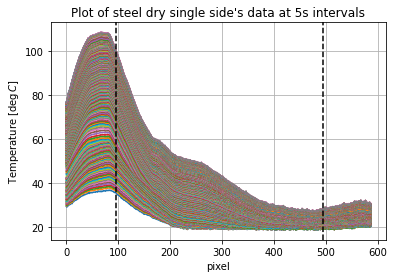

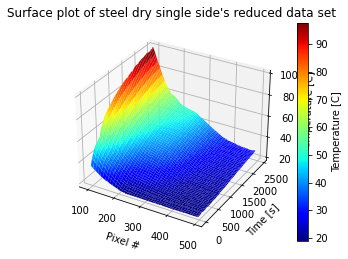

{'start_pix': 80, 'end_pix': 480, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2410, 't_interval': 5}
Using meta parameters {'start_pix': 80, 'end_pix': 480, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2410, 't_interval': 5}


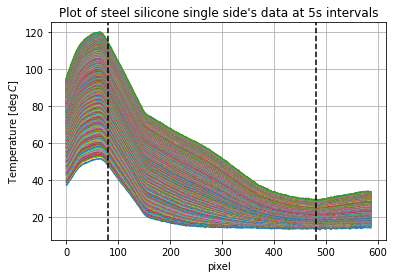

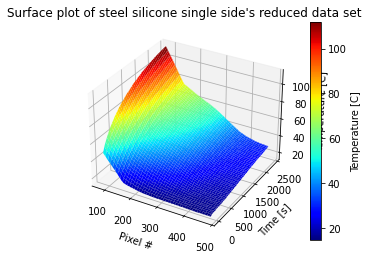

{'start_pix': 95, 'end_pix': 495, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2420, 't_interval': 5}
Using meta parameters {'start_pix': 95, 'end_pix': 495, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2420, 't_interval': 5}


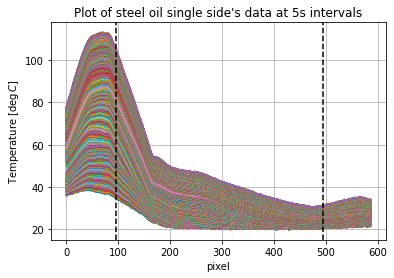

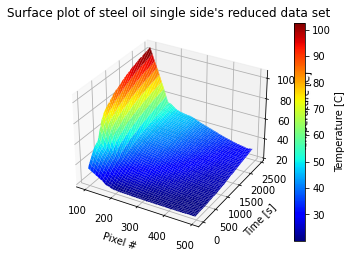

{'start_pix': 65, 'end_pix': 465, 'pix_spacing': 1, 'start_t': 0, 'end_t': 1270, 't_interval': 5}
Using meta parameters {'start_pix': 65, 'end_pix': 465, 'pix_spacing': 1, 'start_t': 0, 'end_t': 1270, 't_interval': 5}


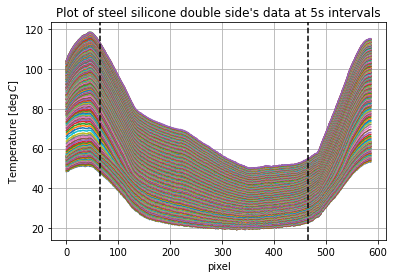

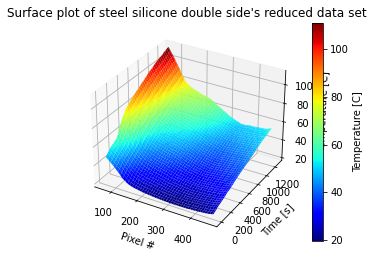

{'start_pix': 75, 'end_pix': 475, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2395, 't_interval': 5}
Using meta parameters {'start_pix': 75, 'end_pix': 475, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2395, 't_interval': 5}


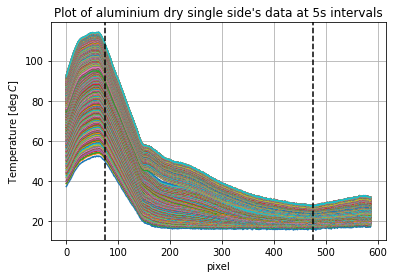

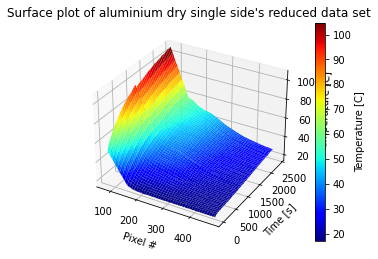

{'start_pix': 80, 'end_pix': 480, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2800, 't_interval': 5}
Using meta parameters {'start_pix': 80, 'end_pix': 480, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2800, 't_interval': 5}


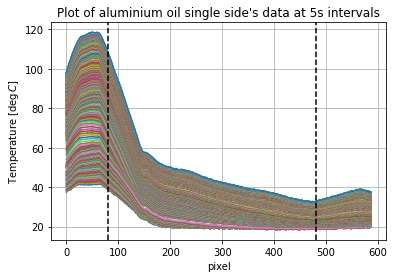

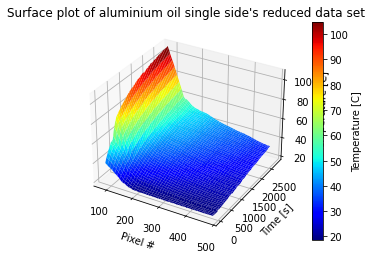

In [19]:
# Load experimental data and select the "relevant" data
steel_ss_dry.set_meta_params(start_pix=95, end_pix=495, pix_spacing=1, plot_2d=True, plot_3d=False, plot_3d_reduced=True)
steel_ss_silicone.set_meta_params(start_pix=80, end_pix=480, pix_spacing=1, plot_2d=True, plot_3d_reduced=True)
steel_ss_oil.set_meta_params(start_pix=95, end_pix=495, pix_spacing=1, plot_2d=True, plot_3d_reduced=True)
steel_ds_silicone.set_meta_params(start_pix=65, end_pix=465, pix_spacing=1, plot_2d=True, plot_3d_reduced=True)
aluminium_ss_dry.set_meta_params(start_pix=75, end_pix=475, pix_spacing=1, plot_2d=True, plot_3d_reduced=True)
aluminium_ss_oil.set_meta_params(start_pix=80, end_pix=480, pix_spacing=1, plot_2d=True, plot_3d_reduced=True)

In [9]:
# Plot temperature profiles
for instance in Experiment.get_instances():
    instance.temp_profile(plot_2d=False, plot_3d=False)

Using meta parameters {'start_pix': 75, 'end_pix': 475, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2395, 't_interval': 500}
Using meta parameters {'start_pix': 65, 'end_pix': 465, 'pix_spacing': 1, 'start_t': 0, 'end_t': 1270, 't_interval': 500}
Using meta parameters {'start_pix': 95, 'end_pix': 495, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2435, 't_interval': 500}
Using meta parameters {'start_pix': 95, 'end_pix': 495, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2420, 't_interval': 500}
Using meta parameters {'start_pix': 80, 'end_pix': 480, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2410, 't_interval': 500}
Using meta parameters {'start_pix': 80, 'end_pix': 480, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2800, 't_interval': 500}


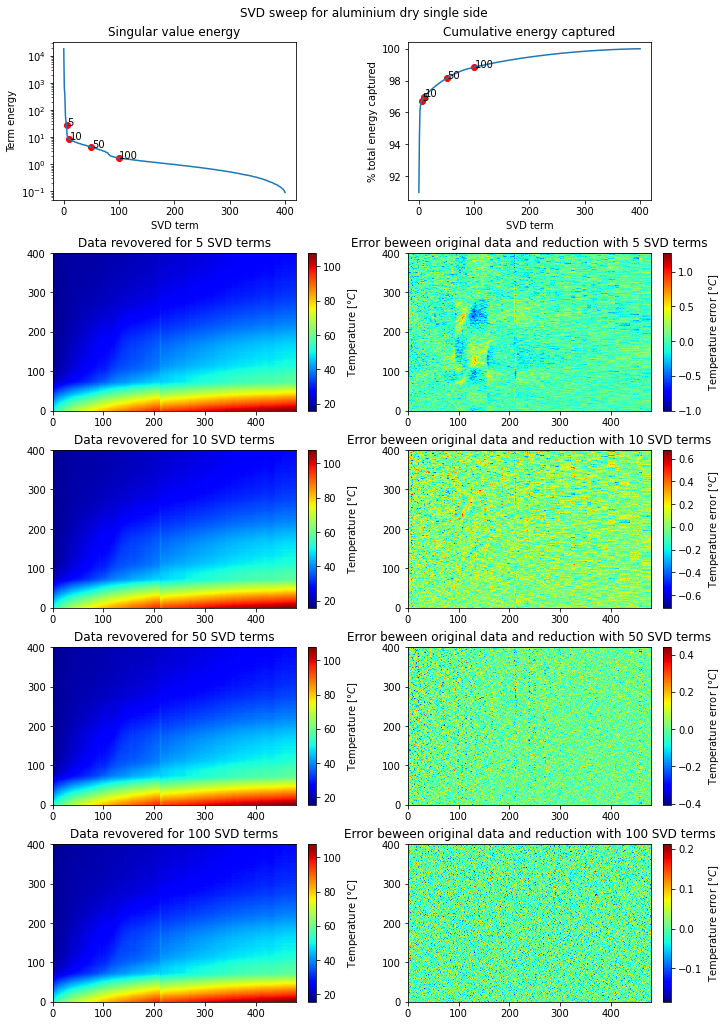

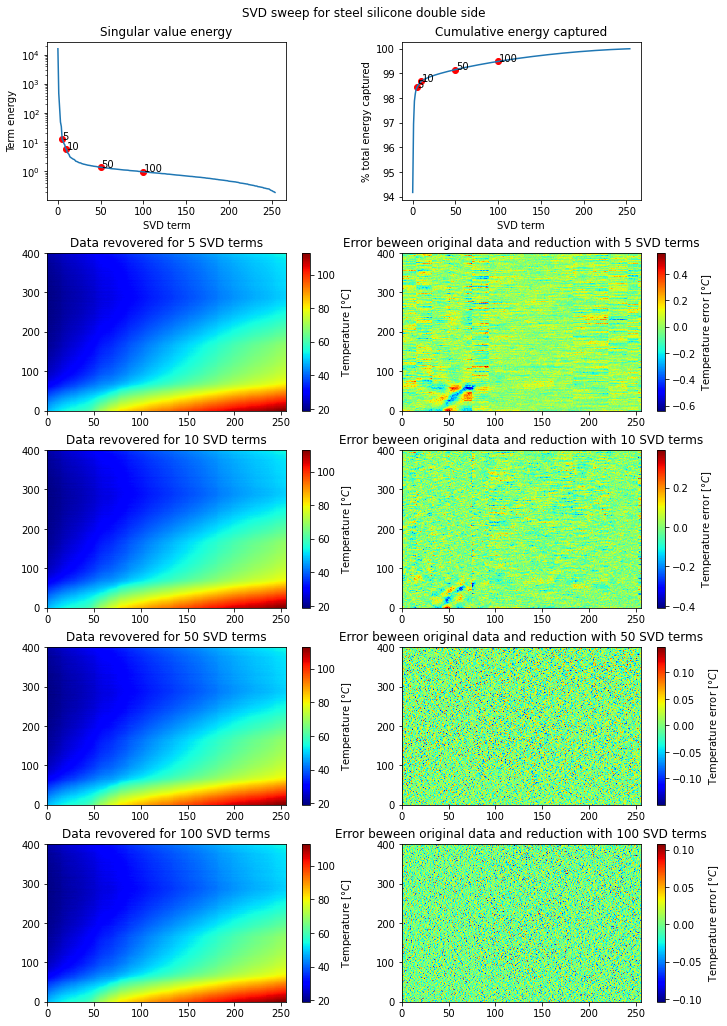

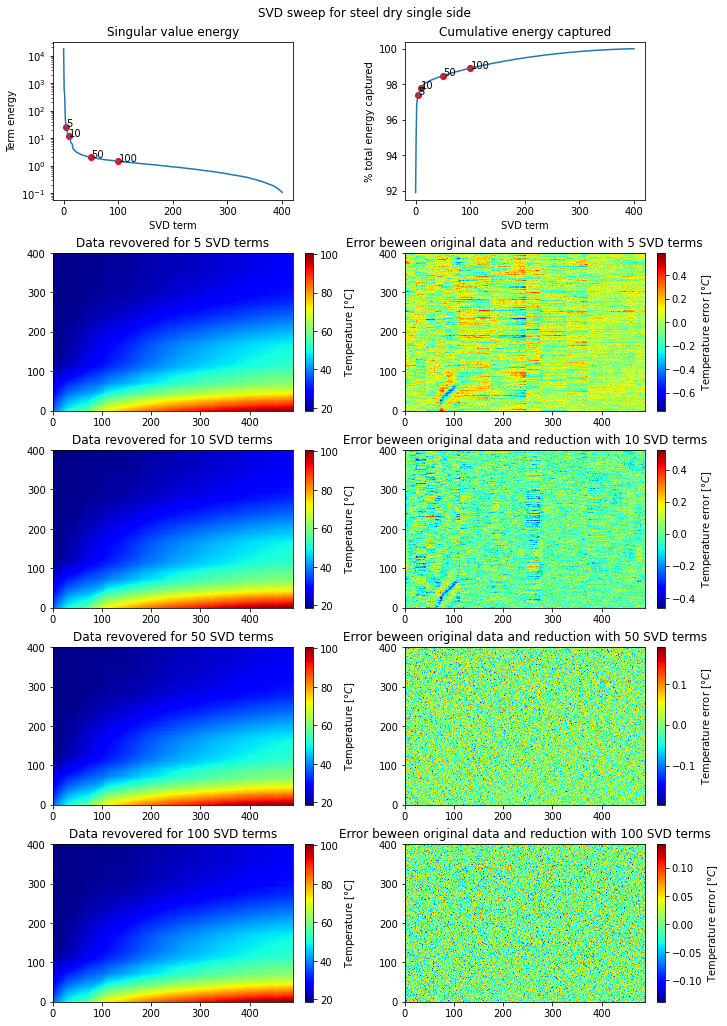

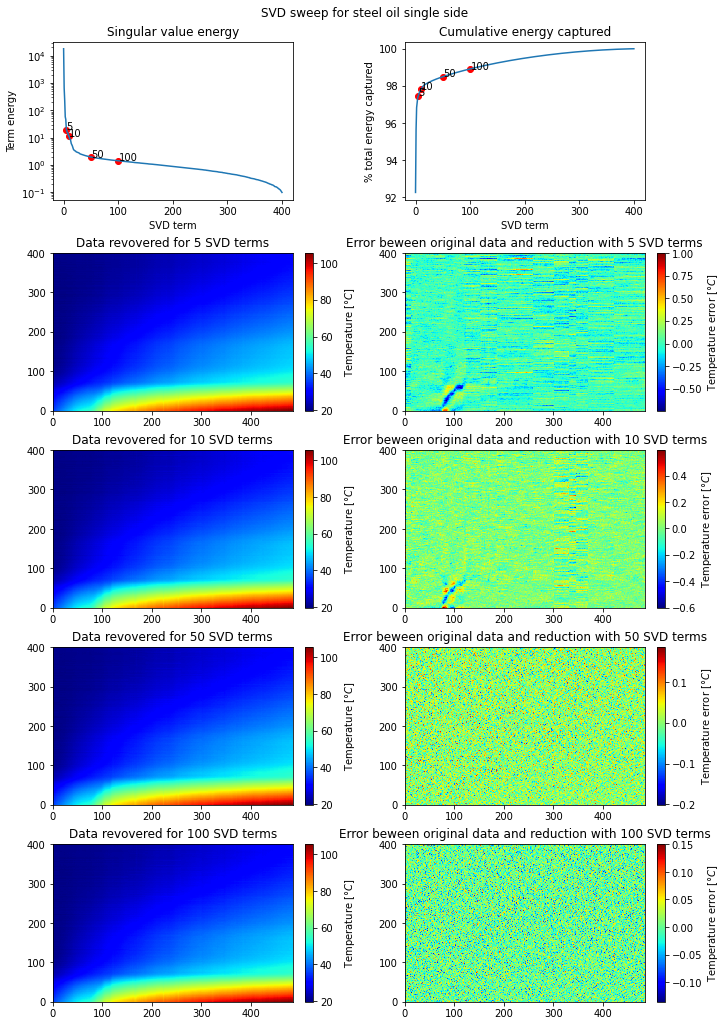

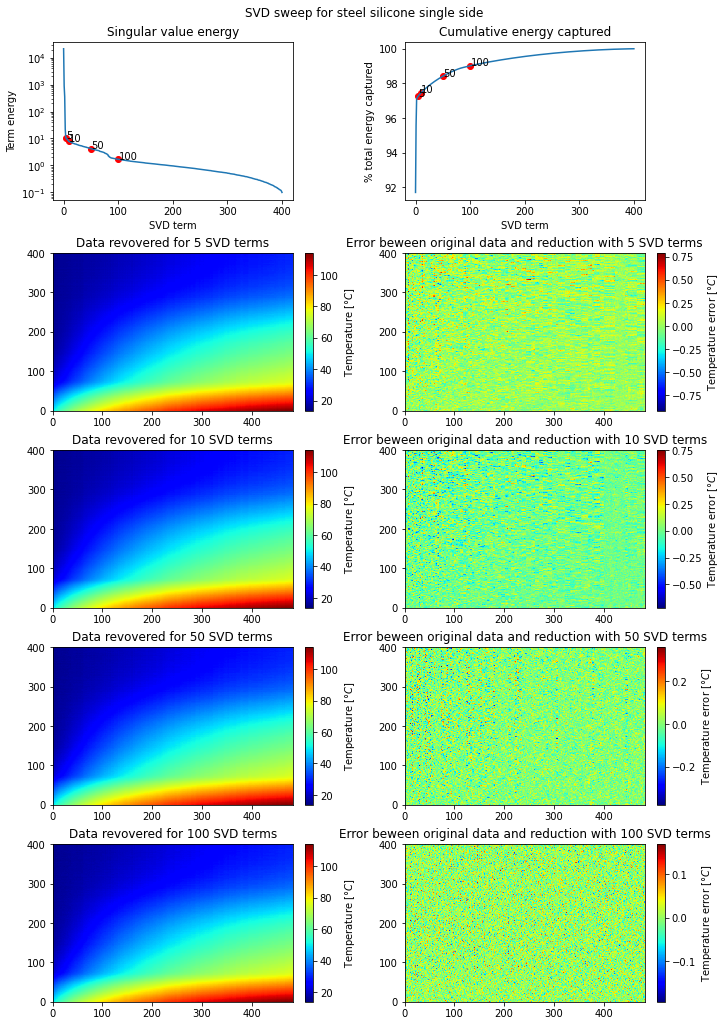

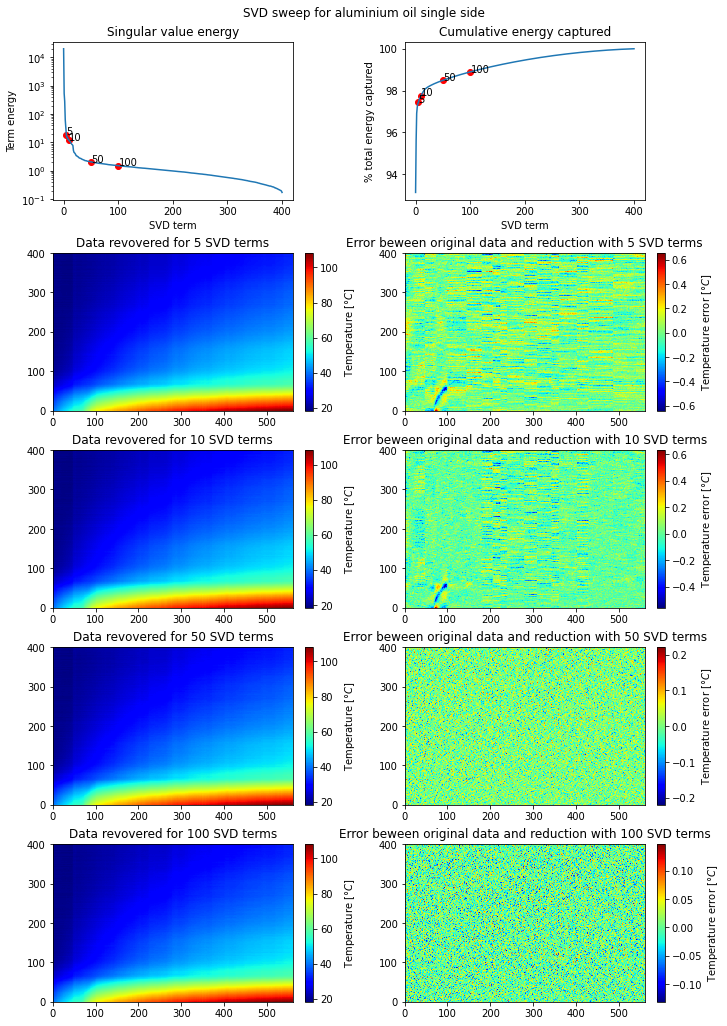

In [10]:
# Investivate the effect of varying the number of SVD terms
for instance in Experiment.get_instances():
    instance.SVD_scan(save_fig=False)

In [11]:
#X, (U, S, VT) = steel_ss_silicone.SVD(50)

In [12]:
# Investigate the effect of using the "Optimal Hard Threshold Value"
#for instance in Experiment.get_instances():
#    instance.SVD_scan_hard_threshold()

In [13]:
# Create cross valiation data sets
for instance in Experiment.get_instances():
    instance.time_seriesCV(data=None)

Aluminium dry single side's creation of cross validation data sets
CV 1:	 TRAIN times:[0:395]s 	 TEST times: [400:795]s
CV 2:	 TRAIN times:[0:795]s 	 TEST times: [800:1195]s
CV 3:	 TRAIN times:[0:1195]s 	 TEST times: [1200:1595]s
CV 4:	 TRAIN times:[0:1595]s 	 TEST times: [1600:1995]s
CV 5:	 TRAIN times:[0:1995]s 	 TEST times: [2000:2395]s


******************************************************************************************


Steel silicone double side's creation of cross validation data sets
CV 1:	 TRAIN times:[0:220]s 	 TEST times: [225:430]s
CV 2:	 TRAIN times:[0:430]s 	 TEST times: [435:640]s
CV 3:	 TRAIN times:[0:640]s 	 TEST times: [645:850]s
CV 4:	 TRAIN times:[0:850]s 	 TEST times: [855:1060]s
CV 5:	 TRAIN times:[0:1060]s 	 TEST times: [1065:1270]s


******************************************************************************************


Steel dry single side's creation of cross validation data sets
CV 1:	 TRAIN times:[0:410]s 	 TEST times: [415:815]s
CV 2:	 TRAIN ti

In [14]:
# Check the effect of the size of the training set

for instance in Experiment.get_instances():
    print(f" \n{instance.title} cross-validation")
    for cv_set in instance.CV_data.keys():
        X_train = instance.CV_data[cv_set]["X_train"]
        X_test = instance.CV_data[cv_set]["X_test"]
        
        y_train = instance.CV_data[cv_set]["y_train"]
        y_test = instance.CV_data[cv_set]["y_test"]
        
        print(f"CV set: {cv_set} \t Training_times = {X_train[0][0][0], X_train[0][-1][0]} s \t Testing_times = {X_test[0][0][0], X_test[0][-1][0]} s")
        
        #mean_squared_error(
        #for model in models:

        #print(f"X_test =\n {X_test}")
        
        #print(f"y_train =\n {y_train}")
        #print(f"y_test =\n {y_test}")  
        
        # Select model
        
        #model = ps.SINDy()
        
        #print("\n ************************************************************************ \n")

 
Aluminium dry single side cross-validation
CV set: 1 	 Training_times = (0, 395) s 	 Testing_times = (400, 795) s
CV set: 2 	 Training_times = (0, 795) s 	 Testing_times = (800, 1195) s
CV set: 3 	 Training_times = (0, 1195) s 	 Testing_times = (1200, 1595) s
CV set: 4 	 Training_times = (0, 1595) s 	 Testing_times = (1600, 1995) s
CV set: 5 	 Training_times = (0, 1995) s 	 Testing_times = (2000, 2395) s
 
Steel silicone double side cross-validation
CV set: 1 	 Training_times = (0, 220) s 	 Testing_times = (225, 430) s
CV set: 2 	 Training_times = (0, 430) s 	 Testing_times = (435, 640) s
CV set: 3 	 Training_times = (0, 640) s 	 Testing_times = (645, 850) s
CV set: 4 	 Training_times = (0, 850) s 	 Testing_times = (855, 1060) s
CV set: 5 	 Training_times = (0, 1060) s 	 Testing_times = (1065, 1270) s
 
Steel dry single side cross-validation
CV set: 1 	 Training_times = (0, 410) s 	 Testing_times = (415, 815) s
CV set: 2 	 Training_times = (0, 815) s 	 Testing_times = (820, 1220) s
C

In [15]:
# Define the model

poly_order = 5
threshold = 0.05

# Fit the model for the data
for instance in Experiment.get_instances():
    for i in range(len(instance.cv_X_train)):
        model = ps.SINDy(
                    optimizer=ps.STLSQ(threshold=threshold),
                    feature_library=ps.PolynomialLibrary(degree=poly_order),
        )
        
        pixel_offset = 150
        #X_train = instance.cv_X_train[i]
        y_train = instance.cv_y_train[i]
        y = y_train[pixel_offset,:]
        model.fit(y)
        model.print()
        
        #X_test = instance.cv_X_test[i]
        #y_test = instance.cv_y_test[i]


# Experimental area

## PySINDY
### Single pixel over time

X_train, X_test, y_train, y_test = steel_ss_dry.X_train5, steel_ss_dry.X_test5, steel_ss_dry.y_train5, steel_ss_dry.y_test5

pixel_offset = 200

y = y_train[pixel_offset,:]

plt.plot(y)

index = 0
t_train = np.zeros_like(X_train[0,:])
for i in X_train[0,:]:
    t_train[index] = i[0]
    index +=1

index = 0
t_test = np.zeros_like(X_test[0,:])
for i in X_test[0,:]:
    t_test[index] = i[0]
    index +=1
    
# t_test = np.concatenate((t_train, t_test))

#### Train the model

stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.05) # Sequentiall thresholded least squares
lasso_optimizer = Lasso(alpha=2, max_iter=2000, fit_intercept=False) # LASSO
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(y, t=t_train)
model.print()

#### Predict derivatives with learned model

x_dot_test_predicted = model.predict(t_test)
x_dot_test_computed = model.differentiate(t_test, t=t_test) #[1]-t_test[0])

plt.cla()

plt.plot(t_test, x_dot_test_computed, "r--", label="model predition")
plt.plot(t_test, x_dot_test_predicted, "k", label="numerical derivative")
plt.legend()
plt.show()

# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit(X_train)
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()

### All pixels over time

## Polynomial Regression

for deg in range(1,10):
    steel_ss_silicone.polyreg(steel_ss_silicone.reduced_data.index, steel_ss_silicone.reduced_data[0], deg)